# Capstone Project: Transformers detection, temperature extraction and fault detection

### Step 1: Importing critical libraries and functions

In [25]:
#Uncomment the install the following libraries when running for the first time
# !pip install flirimageextractor
# !pip install loguru
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install PyQt5
# !pip install tk #ensure 'conda install tk' is run on anaconda command prompt
#Importing all relevant libraries
from tkinter import * 
import time 
st = time.time() # get the start time
import cv2
import numpy as np
import pandas as pd
from os import listdir, mkdir
from os.path import isfile, join, split, splitext
import io
import json
import os.path
import re
import csv
import subprocess
from PIL import Image, ImageEnhance
from math import sqrt, exp, log
from matplotlib import cm

import glob
import cv2
from matplotlib import pyplot as plt, cm
import argparse
import os
import platform
import sys
from pathlib import Path
import torch
import pytesseract as ocr
import time
import csv
import logging


### Step 2: Defining custom modules/functions for Object detection for visible images and Region of Interest/Hotspot Detection for thermal images

##### Step 2.1 Defining the path and loading the pre-requisites  - Defining libraries

In [26]:
#Changing directory to the current location form where the file is picked 
!cd 
#Dynamically defining the path of the input data to the file 
image_path = os.getcwd()+str('\\datasetsVisibleImages')
image_path

#Defining the dynamic path for the dataset images
FILE = Path(image_path).resolve()
ROOT = FILE.parents[0]  
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  

#Importing pre-requisite libraries on utilities for detection
from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadScreenshots, LoadStreams
from utils.general import (LOGGER, Profile, check_file, check_img_size, check_imshow, check_requirements, colorstr, cv2,
                           increment_path, non_max_suppression, print_args, scale_boxes, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, smart_inference_mode

c:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1


##### Step 2.2 Main detection module for passing parameters, model and reading the input file and writing the images 

Step 2.2.a) The library with the main module called 'run' which when passed variables/parameters of the detection model generates inference using YOLO45 models and saves detection inferences in an output 

In [27]:
#Main detection module for passing parameters, model and reading the input file and writing the images 
"""
# These modules are taken from https://github.com/ultralytics/yolov5 where the libraries are defined 
# with greater documentation where even video setup can be configured
"""
thermal_ROI_coord = []
thermal_ROI_prob = []
@smart_inference_mode()
def run(
        weights=ROOT / 'yolov5s.pt',  # model path or triton URL
        source=ROOT / 'data/images',  # file/dir/URL/glob/screen/0(webcam)
        data=ROOT / 'data/coco128.yaml',  # dataset.yaml path
        imgsz=(640, 640),  # inference size (height, width)
        conf_thres=0.25,  # confidence threshold
        iou_thres=0.45,  # NMS IOU threshold
        max_det=1000,  # maximum detections per image
        device='',  # cuda device, i.e. 0 or 0,1,2,3 or cpu
        view_img=False,  # show results
        save_txt=False,  # save results to *.txt
        save_conf=False,  # save confidences in --save-txt labels
        save_crop=False,  # save cropped prediction boxes
        nosave=False,  # do not save images/videos
        classes=None,  # filter by class: --class 0, or --class 0 2 3
        agnostic_nms=False,  # class-agnostic NMS
        augment=False,  # augmented inference
        visualize=False,  # visualize features
        update=False,  # update all models
        project=ROOT / 'runs/detect',  # save results to project/name
        name='exp',  # save results to project/name
        exist_ok=False,  # existing project/name ok, do not increment
        line_thickness=3,  # bounding box thickness (pixels)
        hide_labels=False,  # hide labels
        hide_conf=False,  # hide confidences
        half=False,  # use FP16 half-precision inference
        dnn=False,  # use OpenCV DNN for ONNX inference
        vid_stride=1,  # video frame-rate stride
):
    source = str(source)
    save_img = not nosave and not source.endswith('.txt')  # save inference images
    is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)
    is_url = source.lower().startswith(('rtsp://', 'rtmp://', 'http://', 'https://'))
    webcam = source.isnumeric() or source.endswith('.txt') or (is_url and not is_file)
    screenshot = source.lower().startswith('screen')
    if is_url and is_file:
        source = check_file(source)  # download

    # Defining the Directories from where the images are to be saved
    save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Load model
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
    stride, names, pt = model.stride, model.names, model.pt
    imgsz = check_img_size(imgsz, s=stride)  # check image size

    # Dataloader to load it incrementally 
    bs = 1  # batch_size
    if webcam:
        view_img = check_imshow(warn=True)
        dataset = LoadStreams(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)
        bs = len(dataset)
    elif screenshot:
        dataset = LoadScreenshots(source, img_size=imgsz, stride=stride, auto=pt)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)
    vid_path, vid_writer = [None] * bs, [None] * bs

    # Running the inference from the model
    model.warmup(imgsz=(1 if pt or model.triton else bs, 3, *imgsz))  # warmup
    seen, windows, dt = 0, [], (Profile(), Profile(), Profile())
    for path, im, im0s, vid_cap, s in dataset:
        with dt[0]:
            im = torch.from_numpy(im).to(model.device)
            im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
            im /= 255  # 0 - 255 to 0.0 - 1.0
            if len(im.shape) == 3:
                im = im[None]  # expand for batch dim

        # Inference
        with dt[1]:
            visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
            pred = model(im, augment=augment, visualize=visualize)

        # NMS
        with dt[2]:
            pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

        # Second-stage classifier (optional)
        # pred = utils.general.apply_classifier(pred, classifier_model, im, im0s)

        # Process predictions
        for i, det in enumerate(pred):  # per image
            seen += 1
            if webcam:  # batch_size >= 1
                p, im0, frame = path[i], im0s[i].copy(), dataset.count
                s += f'{i}: '
            else:
                p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # im.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # im.txt
            s += '%gx%g ' % im.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            imc = im0.copy() if save_crop else im0  # for save_crop
            annotator = Annotator(im0, line_width=line_thickness, example=str(names))
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()
                # logging.info("******")
                # logging.info(det[:, :4])
                thermal_ROI_coord.append([p.name,det[:, :4]])                
                # Print results
                for c in det[:, 5].unique():
                    n = (det[:, 5] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
                    
                # Write results
                for *xyxy, conf, cls in reversed(det):
                    # logging.info(conf)
                    thermal_ROI_prob.append([p.name,conf]) 
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
                        # logging.info("*****")
                        # logging.info(*xywh)
                        # logging.info(conf)
                        # logging.info(xywh)
                        with open(f'{txt_path}.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or save_crop or view_img:  # Add bbox to image
                        c = int(cls)  # integer class
                        label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                        annotator.box_label(xyxy, label, color=colors(c, True))
                    if save_crop:
                        save_one_box(xyxy, imc, file=project / 'crops' / names[c] / f'{p.stem}.jpg', BGR=True)

            # Stream results
            im0 = annotator.result()
            if view_img:
                if platform.system() == 'Linux' and p not in windows:
                    windows.append(p)
                    cv2.namedWindow(str(p), cv2.WINDOW_NORMAL | cv2.WINDOW_KEEPRATIO)  # allow window resize (Linux)
                    cv2.resizeWindow(str(p), im0.shape[1], im0.shape[0])
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                else:  # 'video' or 'stream'
                    if vid_path[i] != save_path:  # new video
                        vid_path[i] = save_path
                        if isinstance(vid_writer[i], cv2.VideoWriter):
                            vid_writer[i].release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                        save_path = str(Path(save_path).with_suffix('.mp4'))  # force *.mp4 suffix on results videos
                        vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer[i].write(im0)

        # Print time (inference-only)
        LOGGER.info(f"{s}{'' if len(det) else '(no detections), '}{dt[1].dt * 1E3:.1f}ms")

    # Printing the results to the output directory
    t = tuple(x.t / seen * 1E3 for x in dt)  # speeds per image
    LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {(1, 3, *imgsz)}' % t)
    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        LOGGER.info(f"Results saved to {colorstr('bold', save_dir)}{s}")
    if update:
        strip_optimizer(weights[0])  # update model (to fix SourceChangeWarning)


Step 2.2.b) The module called 'parse_opt' which passess the model arguments for object detection in visible images

In [28]:
#Setting all the variables including the model to enable detection
def parse_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', nargs='+', type=str, default=ROOT / 'visible.pt', help='model path or triton URL')
    parser.add_argument('--source', type=str, default=ROOT / 'datasetsVisibleImages', help='file/dir/URL/glob/screen/0(webcam)')
    parser.add_argument('--data', type=str, default=ROOT / 'data/coco128.yaml', help='(optional) dataset.yaml path')
    parser.add_argument('--imgsz', '--img', '--img-size', nargs='+', type=int, default=[640], help='inference size h,w')
    parser.add_argument('--conf-thres', type=float, default=0.25, help='confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.45, help='NMS IoU threshold')
    parser.add_argument('--max-det', type=int, default=1000, help='maximum detections per image')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--view-img', action='store_true', help='show results')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--save-crop', action='store_true', help='save cropped prediction boxes')
    parser.add_argument('--nosave', action='store_true', help='do not save images/videos')
    parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --classes 0, or --classes 0 2 3')
    parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--visualize', action='store_true', help='visualize features')
    parser.add_argument('--update', action='store_true', help='update all models')
    parser.add_argument('--project', default=ROOT / 'runs/detect', help='save results to project/name')
    parser.add_argument('--name', default='exp', help='save results to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--line-thickness', default=3, type=int, help='bounding box thickness (pixels)')
    parser.add_argument('--hide-labels', default=False, action='store_true', help='hide labels')
    parser.add_argument('--hide-conf', default=False, action='store_true', help='hide confidences')
    parser.add_argument('--half', action='store_true', help='use FP16 half-precision inference')
    parser.add_argument('--dnn', action='store_true', help='use OpenCV DNN for ONNX inference')
    parser.add_argument('--vid-stride', type=int, default=1, help='video frame-rate stride')
    #opt = parser.parse_args()
    opt, unknown = parser.parse_known_args()
    opt.imgsz *= 2 if len(opt.imgsz) == 1 else 1  # expand
    print_args(vars(opt))
    return opt


In [29]:
#Setting all the variables including the model to enable detection
def parse_Google_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', nargs='+', type=str, default=ROOT / 'visible.pt', help='model path or triton URL')
    parser.add_argument('--source', type=str, default=ROOT / 'datasetsGoogleImages', help='file/dir/URL/glob/screen/0(webcam)')
    parser.add_argument('--data', type=str, default=ROOT / 'data/coco128.yaml', help='(optional) dataset.yaml path')
    parser.add_argument('--imgsz', '--img', '--img-size', nargs='+', type=int, default=[160], help='inference size h,w')
    parser.add_argument('--conf-thres', type=float, default=0.25, help='confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.45, help='NMS IoU threshold')
    parser.add_argument('--max-det', type=int, default=1000, help='maximum detections per image')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--view-img', action='store_true', help='show results')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--save-crop', action='store_true', help='save cropped prediction boxes')
    parser.add_argument('--nosave', action='store_true', help='do not save images/videos')
    parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --classes 0, or --classes 0 2 3')
    parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--visualize', action='store_true', help='visualize features')
    parser.add_argument('--update', action='store_true', help='update all models')
    parser.add_argument('--project', default=ROOT / 'runs/detect', help='save results to project/name')
    parser.add_argument('--name', default='exp', help='save results to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--line-thickness', default=3, type=int, help='bounding box thickness (pixels)')
    parser.add_argument('--hide-labels', default=False, action='store_true', help='hide labels')
    parser.add_argument('--hide-conf', default=False, action='store_true', help='hide confidences')
    parser.add_argument('--half', action='store_true', help='use FP16 half-precision inference')
    parser.add_argument('--dnn', action='store_true', help='use OpenCV DNN for ONNX inference')
    parser.add_argument('--vid-stride', type=int, default=1, help='video frame-rate stride')
    # opt = parser.parse_args()
    opt, unknown = parser.parse_known_args()
    opt.imgsz *= 2 if len(opt.imgsz) == 1 else 1  # expand
    print_args(vars(opt))
    return opt


Step 2.2.c) The module called 'parse_opt' which passess the model arguments for hotspot/Region of Interest detection in thermal images along with passing the coordinates and probabilities for the same

In [30]:
#Setting all the variables including the model to enable region of interest in thermal images
def parse_thermal_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', nargs='+', type=str, default=ROOT / 'thermal.pt', help='model path or triton URL')
    parser.add_argument('--source', type=str, default=ROOT / 'datasetsThermalImages', help='file/dir/URL/glob/screen/0(webcam)')
    parser.add_argument('--data', type=str, default=ROOT / 'data/coco128.yaml', help='(optional) dataset.yaml path')
    parser.add_argument('--imgsz', '--img', '--img-size', nargs='+', type=int, default=[416], help='inference size h,w')
    parser.add_argument('--conf-thres', type=float, default=0.25, help='confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.45, help='NMS IoU threshold')
    parser.add_argument('--max-det', type=int, default=1000, help='maximum detections per image')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--view-img', action='store_true', help='show results')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--save-crop', default=True, action='store_true', help='save cropped prediction boxes')
    parser.add_argument('--nosave', action='store_true', help='do not save images/videos')
    parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --classes 0, or --classes 0 2 3')
    parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--visualize', action='store_true', help='visualize features')
    parser.add_argument('--update', action='store_true', help='update all models')
    parser.add_argument('--project', default=ROOT / 'runs/detect', help='save results to project/name')
    parser.add_argument('--name', default='expThermal', help='save results to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--line-thickness', default=3, type=int, help='bounding box thickness (pixels)')
    parser.add_argument('--hide-labels', default=True, action='store_true', help='hide labels')
    parser.add_argument('--hide-conf', default=True, action='store_true', help='hide confidences')
    parser.add_argument('--half', action='store_true', help='use FP16 half-precision inference')
    parser.add_argument('--dnn', action='store_true', help='use OpenCV DNN for ONNX inference')
    parser.add_argument('--vid-stride', type=int, default=1, help='video frame-rate stride')
    # opt = parser.parse_args()
    opt, unknown = parser.parse_known_args()
    opt.imgsz *= 2 if len(opt.imgsz) == 1 else 1  # expand
    print_args(vars(opt))
    return opt

#### Step 2.3 Ensuring the pre-trained ML models for object detection and hotspot detection are made and loaded 

For the purpose of this activity, for termination joints a custom data set of joints are annotated, trained, validated and tested in roboflow using YOLOv5. The team has converted the process into code which are shared in the below collab notebooks.
*  Collab Notebook for [Transformers Object Detection](https://colab.research.google.com/drive/1DwhOt56Y0UJ3m6jXeLigzwtRTRfPVs8Q?usp=sharing)

* Collab Notebook for [Transformers Hotspot Detection](https://colab.research.google.com/drive/1JmlugWWX8Weypug-CBTwlwzGPBODf0Rx?usp=sharing)

These offline annotations and files are available in the Material folder under: 
* \Model Training\Object Detection\Transformer_Object_Detection_with_Roboflow_Train_YOLOv5.ipynb
* \Model Training\Thermal Detection\Trasformer_Hotspot_Detection_Roboflow_Train_YOLOv5.ipynb

As inputs, the visual images and thermal images are fed and annotated using roboflow, and the model does the following steps to train our detector:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference

Once the weights are trained for each model, we export the best.pt files to the main location as visible.pt and thermal.pt in the source

### Step 3 Object detection for visible images using trained ML models

#### Step 3.1 Sharing the view for top 25 visible images

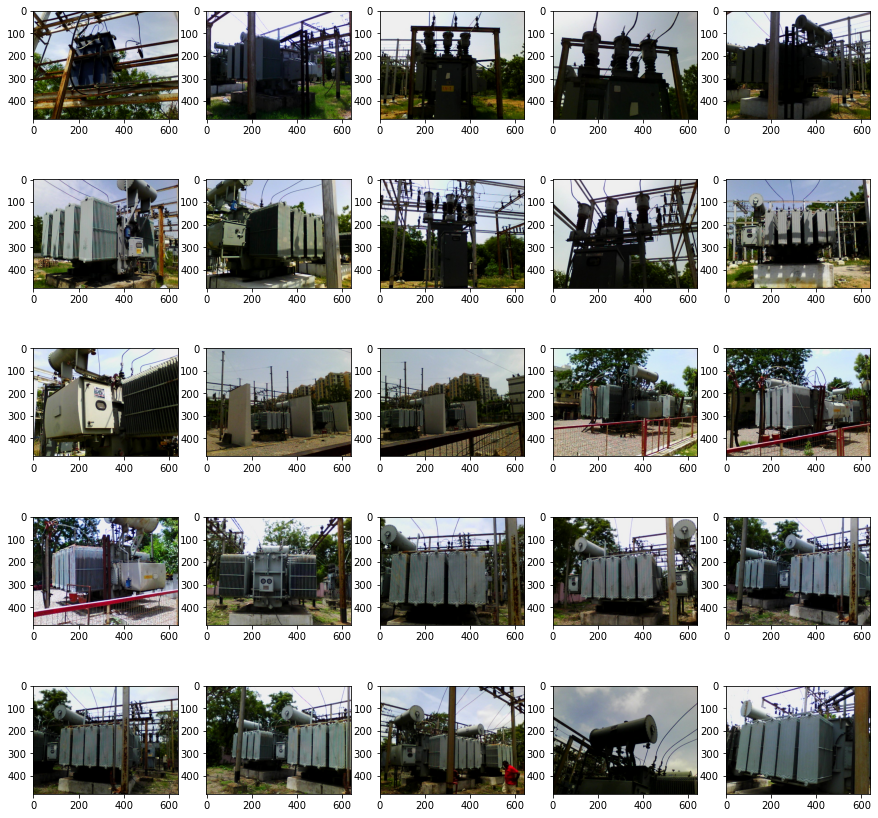

In [31]:
# !pip install pyqt5
from skimage.io import imread
import matplotlib
matplotlib.get_backend() 
#Creating a view for the top 25 current input visible images
img_dir=os.getcwd()+str('\\datasetsVisibleImages')
all_files = [
    join(img_dir, f)
    for f in listdir(img_dir)]
top25files = all_files[:25]
k=0
%matplotlib inline
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15) )
for i in top25files:
    k=k+1
    plt.subplot(5,5,k) 
    plt.imshow(imread(i))
plt.show()

#### Step 3.2 Invoking the 'run' module from 2.2.a by passing variables/parameters custom to visible images to the model to enable object detection 

In [32]:
#Passing the parse paramters to a variable opt
thermal_ROI_coord = []
opt = parse_opt()
#Function to check on the tensorflow requirements for the local system
check_requirements(exclude=('tensorboard', 'thop'))
#Running the main detection function which exports to the detect/exp folder
run(**vars(opt))

733703579: weights=visible.pt, source=datasetsVisibleImages, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-11-8 Python-3.9.7 torch-1.13.0+cpu CPU

Fusing layers... 


requirements: C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\requirements.txt not found, check failed.


Model summary: 157 layers, 7012822 parameters, 0 gradients
image 1/39 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsVisibleImages\FLIR1346.jpg: 480x640 1 transformer, 960.3ms
image 2/39 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsVisibleImages\FLIR1348.jpg: 480x640 1 transformer, 4444.7ms
image 3/39 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsVisibleImages\FLIR1350.jpg: 480x640 1 transformer, 8442.8ms
image 4/39 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsVisibleImages\FLIR1352.jpg: 480x640 1 transformer, 1046.5ms
image 5/39 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsVisibleImages\FLIR1354.jpg: 480x640 2 transformers, 2491.2ms
image 6/39 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsVisibleImages\FLIR1356.jpg: 480x640 2 transformers, 596.5ms
image 7/39 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsVisibleImages\FLIR1358.jpg: 480x640 1 transformer, 749.6ms
image 8/39 C:\Users\tantrivt\Des

#### Step 3.3 Display of the top 25 images from the detect folder with the bounding boxes identifying the object

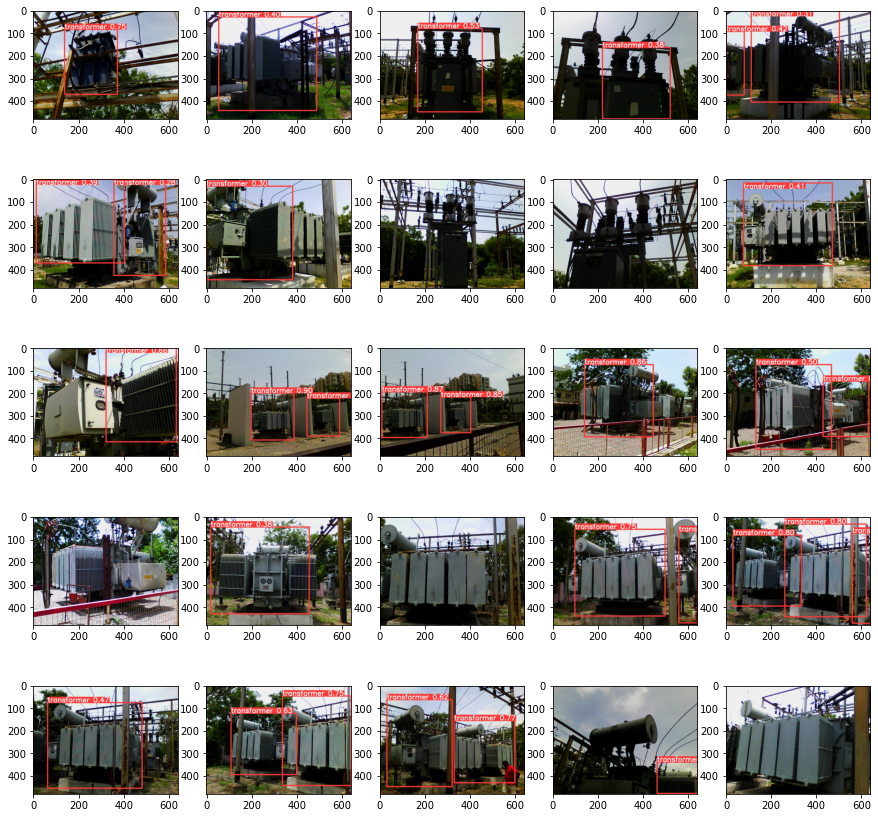

In [33]:
#Creating a view for the top 25 current input visible images post detection with bounding box using visible.pt
img_dir=os.getcwd()+str('\\runs\\detect\\exp')
all_files = [
    join(img_dir, f)
    for f in listdir(img_dir)]
top25files = all_files[:25]
k=0
%matplotlib inline
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15) )
for i in top25files:
    k=k+1
    plt.subplot(5,5,k) 
    plt.imshow(imread(i))
plt.show()

#### Step 3.4 Sharing the view for a few termination joint images from google to test the model

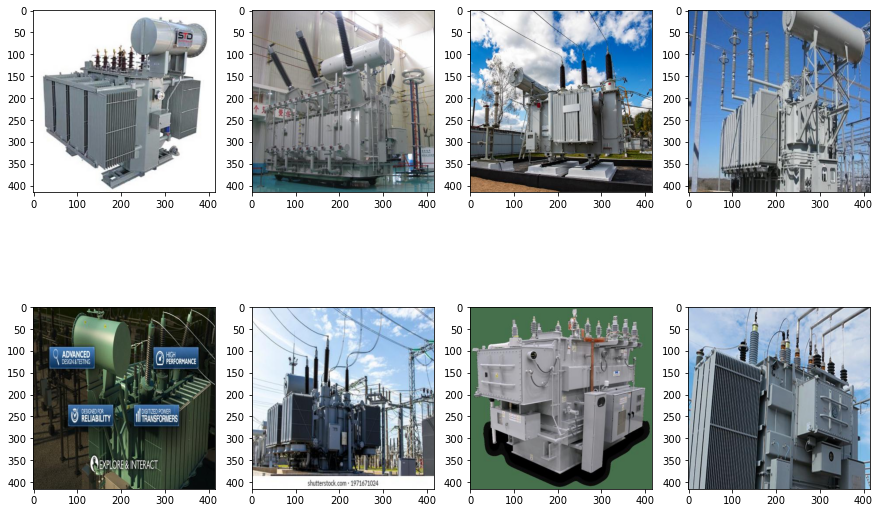

In [34]:
#Creating a view for the top 15 random termination images from google
img_dir=os.getcwd()+str('\\datasetsGoogleImages')
all_files = [
    join(img_dir, f)
    for f in listdir(img_dir)]
top8files = all_files[:8]
k=0
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10) )
for i in top8files:
    k=k+1
    plt.subplot(2,4,k) 
    plt.imshow(imread(i))
plt.show()

#### Step 3.5 Display of the top 25 images from the detect folder with the bounding boxes identifying the object

1963089268: weights=visible.pt, source=datasetsGoogleImages, data=data\coco128.yaml, imgsz=[160, 160], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-11-8 Python-3.9.7 torch-1.13.0+cpu CPU

Fusing layers... 


requirements: C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\requirements.txt not found, check failed.


Model summary: 157 layers, 7012822 parameters, 0 gradients
image 1/16 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsGoogleImages\ia_100000000180_jpg.rf.eeebf5b8ea30fe6bce7975745e05c55d.jpg: 160x160 1 transformer, 234.5ms
image 2/16 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsGoogleImages\ia_100000000197_jpg.rf.103fcc73ebef98326d61e6e550fb4e57.jpg: 160x160 1 transformer, 204.1ms
image 3/16 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsGoogleImages\ia_100000000200_jpg.rf.9cdcc907d6137ad1c8ba8c38ed1eaec9.jpg: 160x160 1 transformer, 567.0ms
image 4/16 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsGoogleImages\ia_100000000226_jpg.rf.5ed71ee27bdadf889ecb81128d75a366.jpg: 160x160 1 transformer, 369.0ms
image 5/16 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsGoogleImages\ia_100000000261_jpg.rf.bc3885c5c964efa0c71cc35dba184fd3.jpg: 160x160 1 transformer, 1851.4ms
image 6/16 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\dat

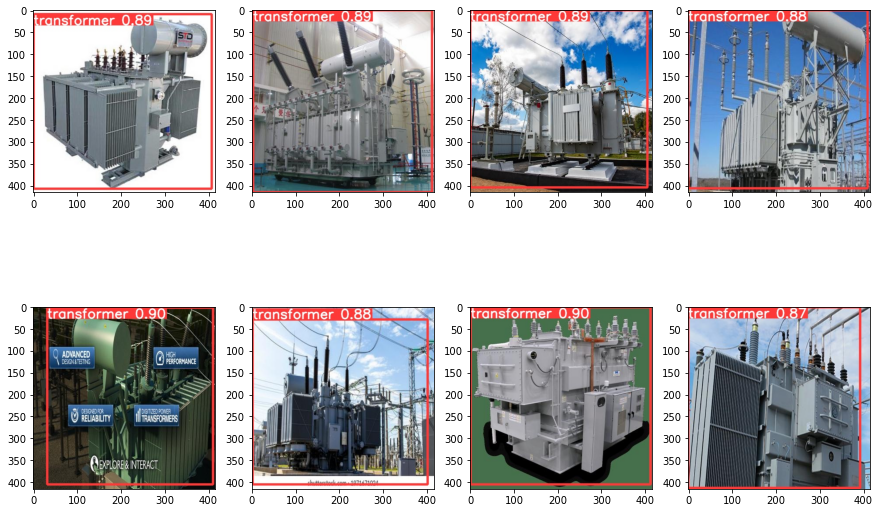

In [35]:
#Passing the parse paramters to a variable opt
thermal_ROI_coord = []
opt = parse_Google_opt()
#Function to check on the tensorflow requirements for the local system
check_requirements(exclude=('tensorboard', 'thop'))
#Running the main detection function which exports to the detect/exp folder
run(**vars(opt))
img_dir=os.getcwd()+str('\\runs\\detect\\exp2')
all_files = [
    join(img_dir, f)
    for f in listdir(img_dir)]
top8files = all_files[:8]
k=0
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10) )
for i in top8files:
    k=k+1
    plt.subplot(2,4,k) 
    plt.imshow(imread(i))
plt.show()

### Step 4 Region of Interest/Hotspot Detection for thermal images using trained ML models

#### Step 4.1 Sharing the view for the top 25 thermal images which goes as input

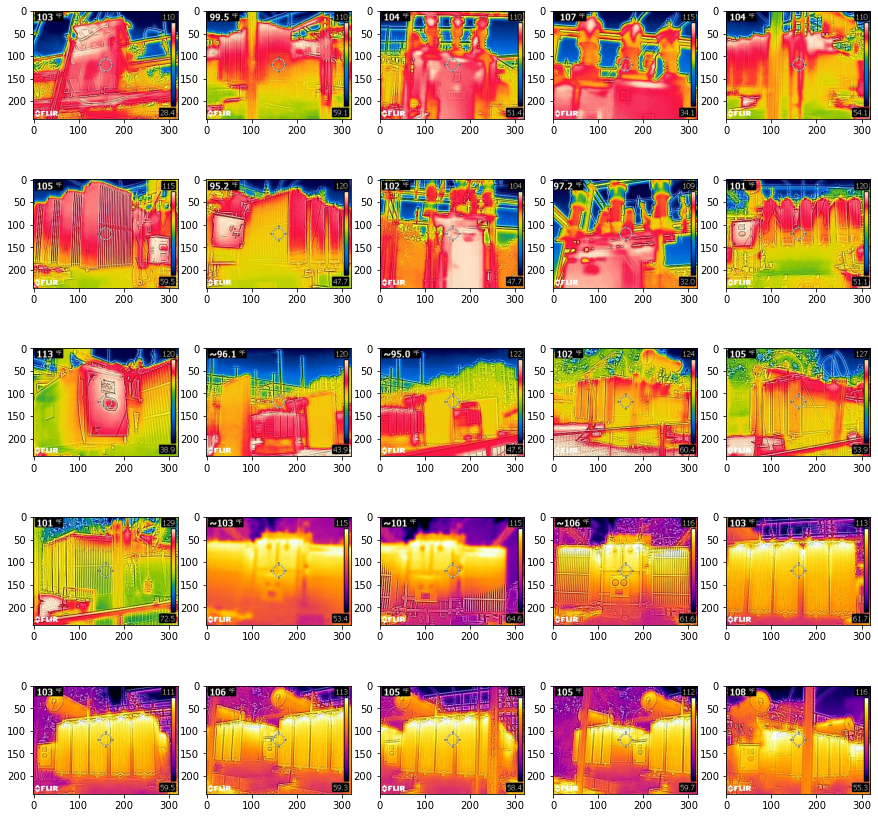

In [36]:
#Creating a view for the top 25 current input thermal images
img_dir=os.getcwd()+str('\\datasetsThermalImages')
all_files = [
    join(img_dir, f)
    for f in listdir(img_dir)]
top25files = all_files[:25]
k=0
%matplotlib inline
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15) )
for i in top25files:
    k=k+1
    plt.subplot(5,5,k) 
    plt.imshow(imread(i))
plt.show()

#### Step 4.2 Invoking the 'run' module from 2.2.a by passing variables/parameters custom to the thermal images model to enable hotspot/ROI detection 

In [37]:
thermal_ROI_coord = [] #Creating an array to capture image name and coordinates of ROIs 
thermal_ROI_prob = [] #Creating an array to capture probability from ROIs  
optThermal = parse_thermal_opt()
#Function to check on the tensorflow requirements for the local system
check_requirements(exclude=('tensorboard', 'thop'))
#Running the main detection function
run(**vars(optThermal)) 
# print(thermal_ROI_coord) #printing the array of arrays

817142404: weights=thermal.pt, source=datasetsThermalImages, data=data\coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=expThermal, exist_ok=False, line_thickness=3, hide_labels=True, hide_conf=True, half=False, dnn=False, vid_stride=1
YOLOv5  2022-11-8 Python-3.9.7 torch-1.13.0+cpu CPU

Fusing layers... 


requirements: C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\requirements.txt not found, check failed.


custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients
image 1/40 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1345.jpg: 320x416 3 ROIs, 666.4ms
image 2/40 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1347.jpg: 320x416 7 ROIs, 2893.4ms
image 3/40 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1349.jpg: 320x416 6 ROIs, 2782.4ms
image 4/40 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1351.jpg: 320x416 3 ROIs, 11799.5ms
image 5/40 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1353.jpg: 320x416 2 ROIs, 7263.5ms
image 6/40 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1355.jpg: 320x416 2 ROIs, 3723.2ms
image 7/40 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1357.jpg: 320x416 3 ROIs, 1667.2ms
image 8/40 C:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsT

#### Step 4.3 Display of the top 25 images from the detect folder with the hotspot detection with multiple Regions of Interest (ROI)

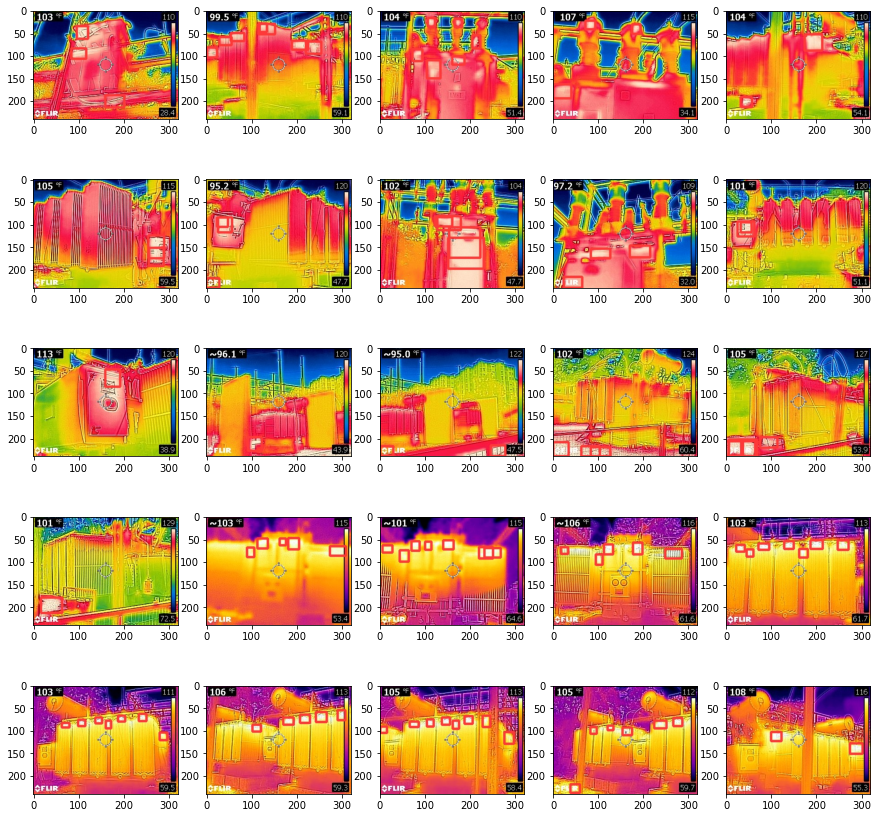

In [38]:
#Creating a view for the top 25 current thermal images with ROI and hotspot detected using thermal.pt

img_dir=os.getcwd()+str('\\runs\\detect\\expThermal')
all_files = [
    join(img_dir, f)
    for f in listdir(img_dir)]
top25files = all_files[:25]
k=0
%matplotlib inline
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15) )
for i in top25files:
    k=k+1
    plt.subplot(5,5,k) 
    plt.imshow(imread(i))
plt.show()

### Step 5: Extracting meta data from the thermal images

#### Step 5.1 Extraction and EDA of the meta data

In [39]:
#Get metadata for each image 
import flirimageextractor
check_flir = flirimageextractor.FlirImageExtractor()
folder_path = os.getcwd()+str('\\datasetsThermalImages') #defining the folder path based on current directory

#Creating a list with the thermal images folder path
thermal_images = [
    join(folder_path, f)
    for f in listdir(folder_path)]

#iteration of the images to invoke the meta data extraction from the file from the thermal image folder
row = 0
meta_df = pd.DataFrame()
for image in thermal_images:
    meta_data = check_flir.get_metadata(image)
    #logging.info(meta_data)
    met_df = pd.DataFrame(meta_data, index = [row])
    row +=1
    meta_df = meta_df.append(met_df)
    print(image+'-Done')


c:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1345.jpg-Done
c:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1347.jpg-Done
c:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1349.jpg-Done
c:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1351.jpg-Done
c:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1353.jpg-Done
c:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1355.jpg-Done
c:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1357.jpg-Done
c:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1359.jpg-Done
c:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1361.jpg-Done
c:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1363.jpg-Done
c:\Users\tantrivt\Desktop\Test\TransfVikram_Trial1\datasetsThermalImages\FLIR1365.jpg-Done

#### Step 5.2 Gathering the stats of critical temperature metrics

In [40]:
#Describing the meta data
meta_df.describe()[['Emissivity', 'IRWindowTransmission', 'PlanckR1',
       'PlanckB', 'PlanckF', 'AtmosphericTransAlpha1',
       'AtmosphericTransAlpha2', 'AtmosphericTransBeta1',
       'AtmosphericTransBeta2', 'AtmosphericTransX']]

Emissivity  IRWindowTransmission      PlanckR1       PlanckB  \
count       40.00                  40.0  4.000000e+01  4.000000e+01   
mean         0.95                   1.0  1.064091e+04  1.298300e+03   
std          0.00                   0.0  5.526487e-12  6.908108e-13   
min          0.95                   1.0  1.064091e+04  1.298300e+03   
25%          0.95                   1.0  1.064091e+04  1.298300e+03   
50%          0.95                   1.0  1.064091e+04  1.298300e+03   
75%          0.95                   1.0  1.064091e+04  1.298300e+03   
max          0.95                   1.0  1.064091e+04  1.298300e+03   

            PlanckF  AtmosphericTransAlpha1  AtmosphericTransAlpha2  \
count  4.000000e+01            4.000000e+01            4.000000e+01   
mean   1.650000e+00            6.569000e-03            1.262000e-02   
std    6.746199e-16            3.513646e-18            7.027291e-18   
min    1.650000e+00            6.569000e-03            1.262000e-02   
25%    1.650000e+00            6.569000e-03            1.262000e-02   
50%    1.650000e+00            6.569000e-03            1.262000e-02   
75%    1.650000e+00            6.569000e-03            1.262000e-02   
max    1.650000e+00            6.569000e-03            1.262000e-02   

       AtmosphericTransBeta1  AtmosphericTransBeta2  AtmosphericTransX  
count              40.000000           4.000000e+01               40.0  
mean               -0.002276          -6.670000e-03                1.9  
std                 0.000000           4.392057e-18                0.0  
min                -0.002276          -6.670000e-03                1.9  
25%                -0.002276          -6.670000e-03                1.9  
50%                -0.002276          -6.670000e-03                1.9  
75%                -0.002276          -6.670000e-03                1.9  
max                -0.002276          -6.670000e-03                1.9

#### Step 5.3 Clearing the other irrelevant meta data and keeping only important columns

In [41]:
meta_df.columns.values.tolist() #all the meta_df
#Loading only required data into a new meta_df_fin table
meta_df_fin = meta_df.filter(['SourceFile',
'FileName',
'FileSize',
'FileType',
'Make',
'Model',
'ImageTemperatureMax',
'ImageTemperatureMin',
'Emissivity',
'ObjectDistance',
'ReflectedApparentTemperature',
'AtmosphericTemperature',
'IRWindowTemperature',
'IRWindowTransmission',
'RelativeHumidity',
'PlanckR1',
'PlanckB',
'PlanckF',
'AtmosphericTransAlpha1',
'AtmosphericTransAlpha2',
'AtmosphericTransBeta1',
'AtmosphericTransBeta2',
'CameraTemperatureRangeMax',
'CameraTemperatureRangeMin',
'CameraModel',
'ImageSize',
'Megapixels']).copy()
meta_df_fin

SourceFile      FileName FileSize  \
0   c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1345.jpg   122 kB   
1   c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1347.jpg    95 kB   
2   c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1349.jpg    89 kB   
3   c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1351.jpg    76 kB   
4   c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1353.jpg    86 kB   
5   c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1355.jpg   107 kB   
6   c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1357.jpg    92 kB   
7   c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1359.jpg   112 kB   
8   c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1361.jpg   101 kB   
9   c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1363.jpg   107 kB   
10  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1365.jpg    93 kB   
11  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1441.jpg    89 kB   
12  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1443.jpg    92 kB   
13  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1497.jpg   127 kB   
14  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1499.jpg   123 kB   
15  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1501.jpg   136 kB   
16  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1575.jpg    52 kB   
17  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1577.jpg    82 kB   
18  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1581.jpg   116 kB   
19  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1583.jpg    93 kB   
20  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1585.jpg   101 kB   
21  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1587.jpg   104 kB   
22  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1589.jpg   100 kB   
23  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1591.jpg   104 kB   
24  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1593.jpg    96 kB   
25  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1595.jpg    75 kB   
26  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1601.jpg    88 kB   
27  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1603.jpg    95 kB   
28  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1605.jpg   112 kB   
29  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1607.jpg   117 kB   
30  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1633.jpg    74 kB   
31  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1635.jpg    73 kB   
32  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1645.jpg    82 kB   
33  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1673.jpg   114 kB   
34  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1675.jpg   113 kB   
35  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1683.jpg   101 kB   
36  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1685.jpg   100 kB   
37  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1941.jpg    96 kB   
38  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR1953.jpg    86 kB   
39  c:/Users/tantrivt/Desktop/Test/TransfVikram_Tr...  FLIR2353.jpg    91 kB   

   FileType             Make  ... CameraTemperatureRangeMax  \
0      JPEG  FLIR Systems AB  ...                   150.0 C   
1      JPEG  FLIR Systems AB  ...                   150.0 C   
2      JPEG  FLIR Systems AB  ...                   150.0 C   
3      JPEG  FLIR Systems AB  ...                   150.0 C   
4      JPEG  FLIR Systems AB  ...                   150.0 C   
5      JPEG  FLIR Systems AB  ...                   150.0 C   
6      JPEG  FLIR Systems AB  ...                   150.0 C   
7      JPEG  FLIR Systems AB  ...                   150.0 C   
8      JPEG  FLIR Systems AB  ...                   150.0 C   
9      JPEG  FLIR Systems AB  ...                   150.0 C   
10     JPEG  FLIR Systems AB  ...                   150.0 C   
11    

### Step 6: Extraction of ROI/Hotspot Coordinates and probability from the thermal images

#### Step 6.1 Creating a dataframe of the ROI coordinates from the tensor

In [42]:
#Loading the original dataset to a dataframe
roi_df = pd.DataFrame(thermal_ROI_coord)
roi_df.columns =['ImgName', 'Coordinates']
# roi_df.to_csv('data.csv')
print(roi_df)

         ImgName                                        Coordinates
0   FLIR1345.jpg  [[tensor(84.), tensor(84.), tensor(117.), tens...
1   FLIR1347.jpg  [[tensor(2.), tensor(82.), tensor(24.), tensor...
2   FLIR1349.jpg  [[tensor(105.), tensor(17.), tensor(121.), ten...
3   FLIR1351.jpg  [[tensor(71.), tensor(23.), tensor(93.), tenso...
4   FLIR1353.jpg  [[tensor(173.), tensor(53.), tensor(212.), ten...
5   FLIR1355.jpg  [[tensor(254.), tensor(124.), tensor(289.), te...
6   FLIR1357.jpg  [[tensor(26.), tensor(84.), tensor(57.), tenso...
7   FLIR1359.jpg  [[tensor(121.), tensor(83.), tensor(159.), ten...
8   FLIR1361.jpg  [[tensor(83.), tensor(153.), tensor(126.), ten...
9   FLIR1363.jpg  [[tensor(32.), tensor(95.), tensor(56.), tenso...
10  FLIR1365.jpg  [[tensor(159.), tensor(49.), tensor(192.), ten...
11  FLIR1441.jpg  [[tensor(92.), tensor(198.), tensor(123.), ten...
12  FLIR1443.jpg  [[tensor(244.), tensor(216.), tensor(276.), te...
13  FLIR1497.jpg  [[tensor(0.), tensor(209.), te

#### Step 6.2 Exploding the dataframe and cleaning the tensor vectors to extract coordinates

In [43]:
#exploding the arrays having multiple ROIs
roi_exp_df = roi_df.explode('Coordinates').reset_index(drop=True) 
#splitting the lists into 4 coordinates in each columns for top right and bottom left 
roi_exp_coord = pd.DataFrame(roi_exp_df['Coordinates'].to_list(), columns=['TopLeft_y1','TopLeft_x1','BottomRight_y2','BottomRight_x2'])
#concatenating the data for image and ROI coordinates
roi_exp_fin = pd.concat([roi_exp_df,roi_exp_coord],axis=1)
#Dropping unwanted columns
roi_exp_fin = roi_exp_fin.drop('Coordinates', axis=1)
#Dropping tensor details and extracting temperature integer values from the column names
roi_exp_fin['TopLeft_x1'] = roi_exp_fin['TopLeft_x1'].astype(str).str.replace('tensor.','')
roi_exp_fin['TopLeft_x1'] = roi_exp_fin['TopLeft_x1'].astype(str).str.replace('.\)','').astype(int)
roi_exp_fin['TopLeft_y1'] = roi_exp_fin['TopLeft_y1'].astype(str).str.replace('tensor.','')
roi_exp_fin['TopLeft_y1'] = roi_exp_fin['TopLeft_y1'].astype(str).str.replace('.\)','').astype(int)
roi_exp_fin['BottomRight_x2'] = roi_exp_fin['BottomRight_x2'].astype(str).str.replace('tensor.','')
roi_exp_fin['BottomRight_x2'] = roi_exp_fin['BottomRight_x2'].astype(str).str.replace('.\)','').astype(int)
roi_exp_fin['BottomRight_y2'] = roi_exp_fin['BottomRight_y2'].astype(str).str.replace('tensor.','')
roi_exp_fin['BottomRight_y2'] = roi_exp_fin['BottomRight_y2'].astype(str).str.replace('.\)','').astype(int)
roi_exp_fin

C:\Users\tantrivt\AppData\Local\Temp/ipykernel_34632/4077342265.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  roi_exp_fin['TopLeft_x1'] = roi_exp_fin['TopLeft_x1'].astype(str).str.replace('tensor.','')
C:\Users\tantrivt\AppData\Local\Temp/ipykernel_34632/4077342265.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  roi_exp_fin['TopLeft_x1'] = roi_exp_fin['TopLeft_x1'].astype(str).str.replace('.\)','').astype(int)
C:\Users\tantrivt\AppData\Local\Temp/ipykernel_34632/4077342265.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  roi_exp_fin['TopLeft_y1'] = roi_exp_fin['TopLeft_y1'].astype(str).str.replace('tensor.','')
C:\Users\tantrivt\AppData\Local\Temp/ipykernel_34632/4077342265.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  roi_exp_fin['TopLeft_y1'] = roi_exp_fin['TopLeft

ImgName  TopLeft_y1  TopLeft_x1  BottomRight_y2  BottomRight_x2
0    FLIR1345.jpg          84          84             117             107
1    FLIR1345.jpg          96          35             121              63
2    FLIR1345.jpg         159         187             201             214
3    FLIR1347.jpg           2          82              24             104
4    FLIR1347.jpg         189          67             225              87
..            ...         ...         ...             ...             ...
175  FLIR1953.jpg         164         116             182             135
176  FLIR1953.jpg         144          69             158              83
177  FLIR1953.jpg         213           9             241              33
178  FLIR1953.jpg          70          17              98              37
179  FLIR2353.jpg         197         113             216             140

[180 rows x 5 columns]

#### Step 6.3 Exploding the dataframe and cleaning the tensor vectors to extract probabilities

In [44]:
#Creating a dataframe for the extracted probabilities of the ROIs 
roi_prob_df = pd.DataFrame(thermal_ROI_prob)
roi_prob_df.columns =['ImgName2', 'Prob']
# roi_df.to_csv('data.csv')
roi_prob_df['Prob'] = roi_prob_df['Prob'].astype(str).str.replace('tensor.','')
roi_prob_df['Prob'] = roi_prob_df['Prob'].astype(str).str.replace('.\)','').astype(float)
roi_exp_fin = pd.concat([roi_exp_fin,roi_prob_df],axis=1)
roi_exp_fin = roi_exp_fin.drop('ImgName2', axis=1)
# print(roi_prob_df)
roi_exp_fin

C:\Users\tantrivt\AppData\Local\Temp/ipykernel_34632/3414324272.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  roi_prob_df['Prob'] = roi_prob_df['Prob'].astype(str).str.replace('tensor.','')
C:\Users\tantrivt\AppData\Local\Temp/ipykernel_34632/3414324272.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  roi_prob_df['Prob'] = roi_prob_df['Prob'].astype(str).str.replace('.\)','').astype(float)


ImgName  TopLeft_y1  TopLeft_x1  BottomRight_y2  BottomRight_x2  \
0    FLIR1345.jpg          84          84             117             107   
1    FLIR1345.jpg          96          35             121              63   
2    FLIR1345.jpg         159         187             201             214   
3    FLIR1347.jpg           2          82              24             104   
4    FLIR1347.jpg         189          67             225              87   
..            ...         ...         ...             ...             ...   
175  FLIR1953.jpg         164         116             182             135   
176  FLIR1953.jpg         144          69             158              83   
177  FLIR1953.jpg         213           9             241              33   
178  FLIR1953.jpg          70          17              98              37   
179  FLIR2353.jpg         197         113             216             140   

       Prob  
0    0.2676  
1    0.3575  
2    0.3888  
3    0.2503  
4    0.2619  
..      ...  
175  0.4679  
176  0.6331  
177  0.7514  
178  0.7795  
179  0.4381  

[180 rows x 6 columns]

#### Step 6.4 Rectifying the coordinates automatically where images of portrait mode and landscape mode are automatically normalized

In [45]:
folder_path = os.getcwd()+str('\\datasetsThermalImages')
# image = cv2.imread(filepath)
# height, width = image.shape[:2]
# print(height,width)

for i in roi_exp_fin.index:
    filepath = folder_path+'\\'+roi_exp_fin['ImgName'][i]
    image = cv2.imread(filepath)
    height, width = image.shape[:2] #Gathering width and height for identification of portrait or landscape mode
    if width<height: 
        temp =  roi_exp_fin['TopLeft_y1'][i]
        roi_exp_fin['TopLeft_y1'][i] = roi_exp_fin['TopLeft_x1'][i]
        roi_exp_fin['TopLeft_x1'][i] = temp
        temp2 =  roi_exp_fin['BottomRight_y2'][i]
        roi_exp_fin['BottomRight_y2'][i] = roi_exp_fin['BottomRight_x2'][i]
        roi_exp_fin['BottomRight_x2'][i] = temp2
roi_exp_fin
# roi_exp_fin.to_csv('test.csv')

ImgName  TopLeft_y1  TopLeft_x1  BottomRight_y2  BottomRight_x2  \
0    FLIR1345.jpg          84          84             117             107   
1    FLIR1345.jpg          96          35             121              63   
2    FLIR1345.jpg         159         187             201             214   
3    FLIR1347.jpg           2          82              24             104   
4    FLIR1347.jpg         189          67             225              87   
..            ...         ...         ...             ...             ...   
175  FLIR1953.jpg         164         116             182             135   
176  FLIR1953.jpg         144          69             158              83   
177  FLIR1953.jpg         213           9             241              33   
178  FLIR1953.jpg          70          17              98              37   
179  FLIR2353.jpg         197         113             216             140   

       Prob  
0    0.2676  
1    0.3575  
2    0.3888  
3    0.2503  
4    0.2619  
..      ...  
175  0.4679  
176  0.6331  
177  0.7514  
178  0.7795  
179  0.4381  

[180 rows x 6 columns]

#### Step 6.5 Creating the final dataframe with coordinates and probabilities of ROI along with the image meta data

In [46]:
#merging the meta data with the ROI coordinates
fin_df = pd.merge(roi_exp_fin,meta_df_fin, left_on='ImgName',right_on='FileName', how='left')
fin_df

ImgName  TopLeft_y1  TopLeft_x1  BottomRight_y2  BottomRight_x2  \
0    FLIR1345.jpg          84          84             117             107   
1    FLIR1345.jpg          96          35             121              63   
2    FLIR1345.jpg         159         187             201             214   
3    FLIR1347.jpg           2          82              24             104   
4    FLIR1347.jpg         189          67             225              87   
..            ...         ...         ...             ...             ...   
175  FLIR1953.jpg         164         116             182             135   
176  FLIR1953.jpg         144          69             158              83   
177  FLIR1953.jpg         213           9             241              33   
178  FLIR1953.jpg          70          17              98              37   
179  FLIR2353.jpg         197         113             216             140   

     ...  CameraTemperatureRangeMax CameraTemperatureRangeMin CameraModel  \
0    ...                    150.0 C                   -10.0 C     FLIR C2   
1    ...                    150.0 C                   -10.0 C     FLIR C2   
2    ...                    150.0 C                   -10.0 C     FLIR C2   
3    ...                    150.0 C                   -10.0 C     FLIR C2   
4    ...                    150.0 C                   -10.0 C     FLIR C2   
..   ...                        ...                       ...         ...   
175  ...                    150.0 C                   -10.0 C     FLIR C2   
176  ...                    150.0 C                   -10.0 C     FLIR C2   
177  ...                    150.0 C                   -10.0 C     FLIR C2   
178  ...                    150.0 C                   -10.0 C     FLIR C2   
179  ...                    150.0 C                   -10.0 C     FLIR C2   

    ImageSize Megapixels  
0     320x240      0.077  
1     320x240      0.077  
2     320x240      0.077  
3     320x240      0.077  
4     320x240      0.077  
..        ...        ...  
175   320x240      0.077  
176   320x240      0.077  
177   320x240      0.077  
178   320x240      0.077  
179   320x240      0.077  

[180 rows x 33 columns]

### Step 7: Temperature extraction from the thermal images using exiftool only for the ROI/Hotspot coordinates

#### Step 7.1 Defining the temperature extraction libraries/modules 

Step 7.1.a) Module to get the float value from a dirty string

In [47]:
#Get the float value from a dirty string
def extract_float(dirtystr):
    """
    Extract the float value of a string, helpful for parsing the exiftool data
    :return:
    """
    digits = re.findall(r"[-+]?\d*\.\d+|\d+", dirtystr)
    return float(digits[0])

Step 7.1.b) Module to convert the temperature value from raw meta data  

In [48]:
#function to convert the temperature value from raw meta data  
def raw2temp(raw, E=1, OD=1, RTemp=20, ATemp=20, IRWTemp=20, IRT=1, RH=50, PR1=21106.77, PB=1501, PF=1, PO=-7340,
                PR2=0.012545258):
    """
    convert raw values from the flir sensor to temperatures in C
    # this calculation has been ported to python from
    # https://github.com/gtatters/Thermimage/blob/master/R/raw2temp.R
    # a detailed explanation of what is going on here can be found there
    """

    # constants
    ATA1 = 0.006569
    ATA2 = 0.01262
    ATB1 = -0.002276
    ATB2 = -0.00667
    ATX = 1.9

    # transmission through window (calibrated)
    emiss_wind = 1 - IRT
    refl_wind = 0

    # transmission through the air
    h2o = (RH / 100) * exp(1.5587 + 0.06939 * (ATemp) - 0.00027816 * (ATemp) ** 2 + 0.00000068455 * (ATemp) ** 3)
    tau1 = ATX * exp(-sqrt(OD / 2) * (ATA1 + ATB1 * sqrt(h2o))) + (1 - ATX) * exp(
        -sqrt(OD / 2) * (ATA2 + ATB2 * sqrt(h2o)))
    tau2 = ATX * exp(-sqrt(OD / 2) * (ATA1 + ATB1 * sqrt(h2o))) + (1 - ATX) * exp(
        -sqrt(OD / 2) * (ATA2 + ATB2 * sqrt(h2o)))

    # radiance from the environment
    raw_refl1 = PR1 / (PR2 * (exp(PB / (RTemp + 273.15)) - PF)) - PO
    raw_refl1_attn = (1 - E) / E * raw_refl1
    raw_atm1 = PR1 / (PR2 * (exp(PB / (ATemp + 273.15)) - PF)) - PO
    raw_atm1_attn = (1 - tau1) / E / tau1 * raw_atm1
    raw_wind = PR1 / (PR2 * (exp(PB / (IRWTemp + 273.15)) - PF)) - PO
    raw_wind_attn = emiss_wind / E / tau1 / IRT * raw_wind
    raw_refl2 = PR1 / (PR2 * (exp(PB / (RTemp + 273.15)) - PF)) - PO
    raw_refl2_attn = refl_wind / E / tau1 / IRT * raw_refl2
    raw_atm2 = PR1 / (PR2 * (exp(PB / (ATemp + 273.15)) - PF)) - PO
    raw_atm2_attn = (1 - tau2) / E / tau1 / IRT / tau2 * raw_atm2
    raw_obj = (raw / E / tau1 / IRT / tau2 - raw_atm1_attn -
                raw_atm2_attn - raw_wind_attn - raw_refl1_attn - raw_refl2_attn)
    raw_obj = (raw_obj-32)*(5/9) #Converting from farenheit to celsius 

    # temperature from radiance
    if int(PR1 / (PR2 * (raw_obj + PO)) + PF)>0:
        temp_celcius = PB / log(PR1 / (PR2 * (raw_obj + PO)) + PF) - 273.15
    else:
        temp_celcius = 1298.3 / log(10640.907 / (0.012885059 * (27944.30713 -6046)) + 1.65) - 273.15
    return temp_celcius

Step 7.1.c) Module to extract the temperature value in celscius when image and coordinates are passed

In [49]:

#Extracting the temperature value in celscius when image and coordinates are passed
def extract_thermal_image(imageURL):
    # read image metadata needed for conversion of the raw sensor values
    # E=1,SD=1,RTemp=20,ATemp=RTemp,IRWTemp=RTemp,IRT=1,RH=50,PR1=21106.77,PB=1501,PF=1,PO=-7340,PR2=0.012545258
    meta_json = subprocess.check_output(
        ["exiftool", imageURL, '-Emissivity', '-SubjectDistance', '-AtmosphericTemperature',
         '-ReflectedApparentTemperature', '-IRWindowTemperature', '-IRWindowTransmission', '-RelativeHumidity',
         '-PlanckR1', '-PlanckB', '-PlanckF', '-PlanckO', '-PlanckR2', '-j'])
    meta = json.loads(meta_json.decode())[0]

    # exifread can't extract the embedded thermal image, use exiftool instead
    thermal_img_bytes = subprocess.check_output(
        ["exiftool", "-RawThermalImage", "-b", imageURL])
    thermal_img_stream = io.BytesIO(thermal_img_bytes)

    thermal_img = Image.open(thermal_img_stream)
    thermal_np = np.array(thermal_img)

    # raw values -> temperature
    subject_distance = 1.0
    if 'SubjectDistance' in meta:
        subject_distance = extract_float(meta['SubjectDistance'])

    raw2tempfunc = np.vectorize(lambda x: raw2temp(x, E=meta['Emissivity'], OD=subject_distance,
                                                                          RTemp=extract_float(
                                                                              meta['ReflectedApparentTemperature']),
                                                                          ATemp=extract_float(
                                                                              meta['AtmosphericTemperature']),
                                                                          IRWTemp=extract_float(
                                                                              meta['IRWindowTemperature']),
                                                                          IRT=meta['IRWindowTransmission'],
                                                                          RH=extract_float(
                                                                              meta['RelativeHumidity']),
                                                                          PR1=meta['PlanckR1'], PB=meta['PlanckB'],
                                                                          PF=meta['PlanckF'],
                                                                          PO=meta['PlanckO'], PR2=meta['PlanckR2']))
    thermal_np = raw2tempfunc(thermal_np)
    thermal_np = np.repeat(thermal_np, 4,axis=1)
    thermal_np = np.repeat(thermal_np, 4,axis=0)

    return thermal_np

#library to run in loop for an image and the bounding box coordinates of top left x1,y1 and bottom right x2,y2 
def extract_thermal_temp(image, x1,y1,x2,y2):  #[[20,30,40,50]]
    thermal_image_np = extract_thermal_image(image)
    pixel_values = []
    min_temp = 9999
    max_temp = 0
    delta = 0
    for e in np.ndenumerate(thermal_image_np):
        x, y = e[0]
        c = e[1]
        if((x>=x1 and x<=x2) and (y>=y1 and y<=y2)):
            if(c<min_temp and c>=-10): #Based on the camera max temp
                min_temp = c
            if(c>max_temp and c<=150): #Based on the camera min temp
                max_temp = c
            pixel_values.append([x, y, c])
    #delta = max_temp -min_temp
    # print(np.float64(min_temp).round(), np.float64(max_temp).round())
    return [np.float64(min_temp).round(), np.float64(max_temp).round()]

#### Step 7.2 Extracting the Min and Max temperatures in iterations only over the multiple ROI across all the images

In [50]:
row = 0
ROI_min = []
ROI_max = []
# ROI_delta = []
for i in fin_df.index:
    x1 = fin_df['TopLeft_x1'][i]
    image = fin_df['SourceFile'][i]
    y1 = fin_df['TopLeft_y1'][i]
    x2 = fin_df['BottomRight_x2'][i]
    y2 = fin_df['BottomRight_y2'][i]
    temp = extract_thermal_temp(image,x1,y1,x2,y2)
    ROI_min.append(temp[0])
    ROI_max.append(temp[1])
    # ROI_delta.append(temp[2])
    row +=1
    print(image+'-Done')

fin_df['ROI_min'] = ROI_min
fin_df['ROI_max'] = ROI_max
fin_df


c:/Users/tantrivt/Desktop/Test/TransfVikram_Trial1/datasetsThermalImages/FLIR1345.jpg-Done
c:/Users/tantrivt/Desktop/Test/TransfVikram_Trial1/datasetsThermalImages/FLIR1345.jpg-Done
c:/Users/tantrivt/Desktop/Test/TransfVikram_Trial1/datasetsThermalImages/FLIR1345.jpg-Done
c:/Users/tantrivt/Desktop/Test/TransfVikram_Trial1/datasetsThermalImages/FLIR1347.jpg-Done
c:/Users/tantrivt/Desktop/Test/TransfVikram_Trial1/datasetsThermalImages/FLIR1347.jpg-Done
c:/Users/tantrivt/Desktop/Test/TransfVikram_Trial1/datasetsThermalImages/FLIR1347.jpg-Done
c:/Users/tantrivt/Desktop/Test/TransfVikram_Trial1/datasetsThermalImages/FLIR1347.jpg-Done
c:/Users/tantrivt/Desktop/Test/TransfVikram_Trial1/datasetsThermalImages/FLIR1347.jpg-Done
c:/Users/tantrivt/Desktop/Test/TransfVikram_Trial1/datasetsThermalImages/FLIR1347.jpg-Done
c:/Users/tantrivt/Desktop/Test/TransfVikram_Trial1/datasetsThermalImages/FLIR1347.jpg-Done
c:/Users/tantrivt/Desktop/Test/TransfVikram_Trial1/datasetsThermalImages/FLIR1349.jpg-Done

ImgName  TopLeft_y1  TopLeft_x1  BottomRight_y2  BottomRight_x2  \
0    FLIR1345.jpg          84          84             117             107   
1    FLIR1345.jpg          96          35             121              63   
2    FLIR1345.jpg         159         187             201             214   
3    FLIR1347.jpg           2          82              24             104   
4    FLIR1347.jpg         189          67             225              87   
..            ...         ...         ...             ...             ...   
175  FLIR1953.jpg         164         116             182             135   
176  FLIR1953.jpg         144          69             158              83   
177  FLIR1953.jpg         213           9             241              33   
178  FLIR1953.jpg          70          17              98              37   
179  FLIR2353.jpg         197         113             216             140   

     ...  CameraModel ImageSize Megapixels ROI_min ROI_max  
0    ...      FLIR C2   320x240      0.077     1.0   119.0  
1    ...      FLIR C2   320x240      0.077    -7.0   117.0  
2    ...      FLIR C2   320x240      0.077    -4.0   117.0  
3    ...      FLIR C2   320x240      0.077    -3.0   114.0  
4    ...      FLIR C2   320x240      0.077    -7.0   119.0  
..   ...          ...       ...        ...     ...     ...  
175  ...      FLIR C2   320x240      0.077    -3.0   119.0  
176  ...      FLIR C2   320x240      0.077    -9.0   115.0  
177  ...      FLIR C2   320x240      0.077    -9.0   117.0  
178  ...      FLIR C2   320x240      0.077    -9.0   119.0  
179  ...      FLIR C2   320x240      0.077     6.0   119.0  

[180 rows x 35 columns]

### Step 8: Extracting delta from the min and max temp values in the ROI and determining the fault detection

In [51]:
ROI_temp_delta =[]
ROI_fault_det =[]
threshold = 115 #Defining the threshold for fault data which is subject to the component
# fin_df['Delta'] = ROI_delta
for i in fin_df.index:
    if fin_df['ROI_min'][i]<0:
        delt = fin_df['ROI_max'][i]
    else:   
        delt = fin_df['ROI_max'][i] - fin_df['ROI_min'][i]
    ROI_temp_delta.append(delt)
    if delt>=threshold:
        fault = "PotentialFaultDetected with "+str(fin_df['Prob'][i]*100)+"% probability"
    else:
        fault = "NoFaultDetected with "+str(fin_df['Prob'][i]*100)+"% probability"
    ROI_fault_det.append(fault)
fin_df['ROI_temp_delta'] = ROI_temp_delta
fin_df['ROI_fault_det'] = ROI_fault_det
fin_df['Prob'] = fin_df.pop('Prob') #Pushing the probability to last
fin_df

ImgName  TopLeft_y1  TopLeft_x1  BottomRight_y2  BottomRight_x2  \
0    FLIR1345.jpg          84          84             117             107   
1    FLIR1345.jpg          96          35             121              63   
2    FLIR1345.jpg         159         187             201             214   
3    FLIR1347.jpg           2          82              24             104   
4    FLIR1347.jpg         189          67             225              87   
..            ...         ...         ...             ...             ...   
175  FLIR1953.jpg         164         116             182             135   
176  FLIR1953.jpg         144          69             158              83   
177  FLIR1953.jpg         213           9             241              33   
178  FLIR1953.jpg          70          17              98              37   
179  FLIR2353.jpg         197         113             216             140   

     ... ROI_min ROI_max ROI_temp_delta  \
0    ...     1.0   119.0          118.0   
1    ...    -7.0   117.0          117.0   
2    ...    -4.0   117.0          117.0   
3    ...    -3.0   114.0          114.0   
4    ...    -7.0   119.0          119.0   
..   ...     ...     ...            ...   
175  ...    -3.0   119.0          119.0   
176  ...    -9.0   115.0          115.0   
177  ...    -9.0   117.0          117.0   
178  ...    -9.0   119.0          119.0   
179  ...     6.0   119.0          113.0   

                                         ROI_fault_det    Prob  
0       PotentialFaultDetected with 26.76% probability  0.2676  
1       PotentialFaultDetected with 35.75% probability  0.3575  
2    PotentialFaultDetected with 38.879999999999995...  0.3888  
3              NoFaultDetected with 25.03% probability  0.2503  
4       PotentialFaultDetected with 26.19% probability  0.2619  
..                                                 ...     ...  
175     PotentialFaultDetected with 46.79% probability  0.4679  
176     PotentialFaultDetected with 63.31% probability  0.6331  
177     PotentialFaultDetected with 75.14% probability  0.7514  
178     PotentialFaultDetected with 77.95% probability  0.7795  
179            NoFaultDetected with 43.81% probability  0.4381  

[180 rows x 37 columns]

In [52]:
#Extracting to csv
fin_df.to_csv('fin_df.csv')
# counting unique values
ImgCount = len(pd.unique(fin_df['ImgName']))
ROICount = len(fin_df.index)
print(ImgCount,ROICount)

#Get the execution time
et = time.time() 
#Finalizing the elapsed time
elapsed_time = et - st 
#Print the final execution time
print('Total code execution time is:', elapsed_time/60, 'minutes' ) 
print('This translates to:', elapsed_time/60/ImgCount, 'minutes per image. Total Image Count =',ImgCount )
print('This translates to:', elapsed_time/60/ROICount, 'minutes per ROI. Total ROI Count =',ROICount)


40 180
Total code execution time is: 13.40314093430837 minutes
This translates to: 0.33507852335770927 minutes per image. Total Image Count = 40
This translates to: 0.07446189407949094 minutes per ROI. Total ROI Count = 180


In [53]:
!pip install sweetviz
import pandas as pd
import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(pd.read_csv("fin_df.csv"))

#Saving results to HTML file
sweet_report.show_html('EDA.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:06 -> (00:00 left)


Report EDA.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
